# Principal component analysis of a trajectory

Here we compute the principal component analysis of a trajectory.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests

**Optional packages for visualisation:**

* [nglview](http://nglviewer.org/nglview/latest/api.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import pca, align
import nglview as nv;

import warnings
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [2]:
u = mda.Universe(PSF, DCD)

## Principal component analysis

Principal component analysis is a common linear dimensionality reduction technique that maps the coordinates in each frame of your trajectory to a linear combination of orthogonal vectors. The vectors are called **principal components**, and they are ordered such that the first principal component accounts for the most variance in the original data (i.e. the largest uncorrelated motion in your trajectory), and each successive component accounts for less and less variance. The frame-by-frame conformational fluctuation can be considered a linear combination of the essential dynamics yielded by the PCA. Please see <a data-cite="amadei_essential_1993" href="https://doi.org/https://doi.org/10.1002/prot.340170408">Amadei *et al.*, 1993</a>, <a data-cite="jolliffe_principal_2002" href="https://doi.org/10.1007/b98835">Jolliffe, 2002</a>, <a data-cite="sittel_principal_2014" href="https://doi.org/10.1063/1.4885338">Sittel *et al.*, 2014</a>, or <a data-cite="sittel_perspective_2018" href="https://doi.org/10.1063/1.5049637">Sittel and Stock, 2018</a> for a more in-depth introduction to PCA.

Trajectory coordinates can be transformed onto a lower-dimensional space (*essential subspace*) constructed from these principal components in order to compare conformations. You can thereby visualise the motion described by that component.

In MDAnalysis, the method implemented in the PCA class ([API docs](https://docs.mdanalysis.org/stable/documentation_pages/analysis/pca.html)) is as follows:

1. Optionally align each frame in your trajectory to the first frame.
2. Construct a 3N x 3N covariance for the N atoms in your trajectory. Optionally, you can provide a mean; otherwise the covariance is to the averaged structure over the trajectory.
3. Diagonalise the covariance matrix. The eigenvectors are the principal components, and their eigenvalues are the associated variance.
4. Sort the eigenvalues so that the principal components are ordered by variance.

<div class="alert alert-info">
    
**Note**
    
Principal component analysis algorithms are deterministic, but the solutions are not unique. For example, you could easily change the sign of an eigenvector without altering the PCA. Different algorithms are likely to produce different answers, due to variations in implementation. `MDAnalysis` may not return the same values as another package.

</div>


In [3]:
aligner = align.AlignTraj(u, u, select='backbone',
                          in_memory=True).run()

You can choose how many principal components to save from the analysis with `n_components`. The default value is `None`, which saves all of them. You can also pass a `mean` reference structure to be used in calculating the covariance matrix. With the default value of `None`, the covariance uses the mean coordinates of the trajectory.

In [4]:
pc = pca.PCA(u, select='backbone', 
             align=True, mean=None,
             n_components=None).run()

The principal components are saved in `pc.p_components`. If you kept all the components, you should have an array of shape $(n_{atoms}\times3, n_{atoms}\times3)$.

In [5]:
backbone = u.select_atoms('backbone')
n_bb = len(backbone)
print('There are {} backbone atoms in the analysis'.format(n_bb))
print(pc.p_components.shape)

There are 855 backbone atoms in the analysis
(2565, 2565)


The variance of each principal component is in `pc.variance`. For example, to get the variance explained by the first principal component:

In [6]:
pc.variance[0]

4203.190531283082

This variance is somewhat meaningless by itself. It is much more intuitive to consider the variance of a principal component as a percentage of the total variance in the data. MDAnalysis also tracks the percentage cumulative variance in `pc.cumulated_variance`. As shown below, the first principal component contains 90.3% the total trajectory variance. The first three components combined account for 96.4% of the total variance.

In [7]:
for i in range(3):
    print(f"Cumulated variance: {pc.cumulated_variance[i]:.3f}")

Cumulated variance: 0.903
Cumulated variance: 0.951
Cumulated variance: 0.964


Text(0, 0.5, 'Cumulative variance')

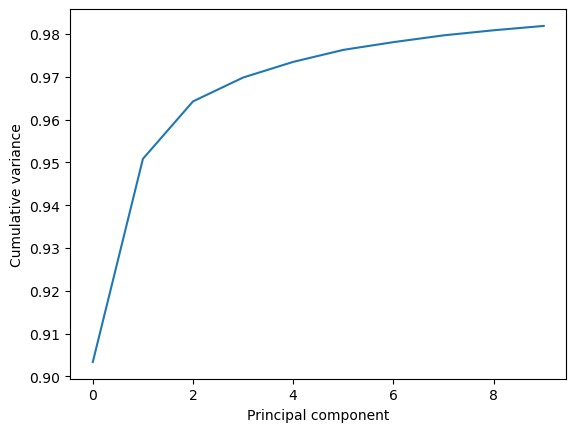

In [8]:
plt.plot(pc.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance')

## Visualising projections into a reduced dimensional space

The `pc.transform()` method transforms a given atom group into weights $\mathbf{w}_i$ over each principal component $i$.

$$ \mathbf{w}_i(t) = (\mathbf{r}(t)-\mathbf{\overline{r}}) \cdot \mathbf{u}_i$$

$\mathbf{r}(t)$ are the atom group coordinates at time $t$, $\mathbf{\overline{r}}$ are the mean coordinates used in the PCA, and $\mathbf{u}_i$ is the $i$th principal component eigenvector $\mathbf{u}$.

While the given atom group must have the same number of atoms that the principal components were calculated over, it does not have to be the same group.

Again, passing `n_components=None` will tranform your atom group over every component. Below, we limit the output to projections over 3 principal components only.

In [9]:
transformed = pc.transform(backbone, n_components=3)
transformed.shape

(98, 3)

The output has the shape (n_frames, n_components). For easier analysis and plotting we can turn the array into a DataFrame.

In [10]:
df = pd.DataFrame(transformed, 
                  columns=['PC{}'.format(i+1) for i in range(3)])
df['Time (ps)'] = df.index * u.trajectory.dt
df.head()

,PC1,PC2,PC3,Time (ps)
0,118.408413,29.088241,15.746624,0.0
1,115.561879,26.786797,14.652498,1.0
2,112.675616,25.038766,12.920274,2.0
3,110.341467,24.306984,11.427098,3.0
4,107.584302,23.464154,11.612104,4.0


There are several ways we can visualise the data. Using the Seaborn's `PairGrid` tool is the quickest and easiest way, if you have seaborn already installed.

<div class="alert alert-info">
    
**Note**

You will need to install the data visualisation library [Seaborn](https://seaborn.pydata.org/installing.html) for this function.

</div>

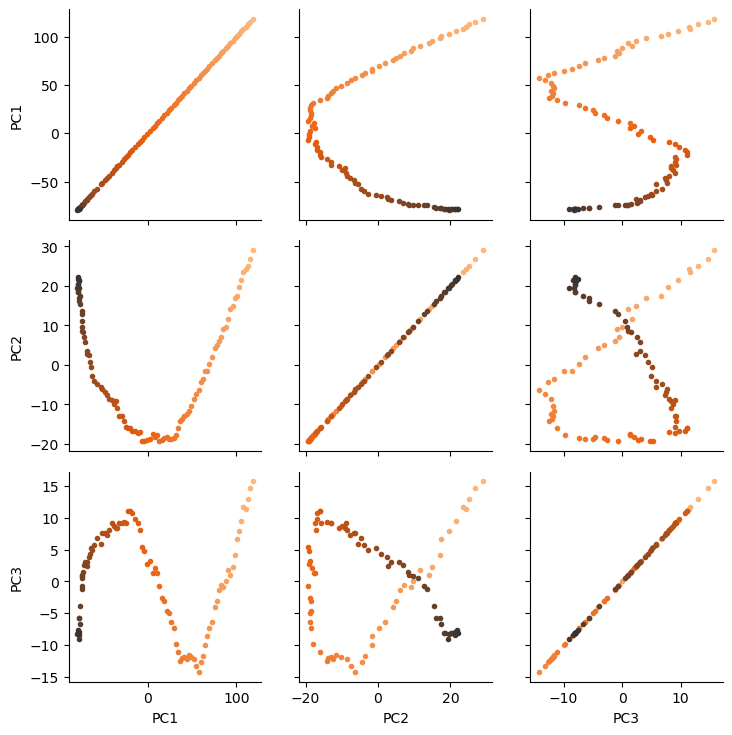

In [11]:
import seaborn as sns

g = sns.PairGrid(df, hue='Time (ps)', 
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df)))
g.map(plt.scatter, marker='.')

Another way to investigate the essential motions of the trajectory is to project the original trajectory onto each of the principal components, to visualise the motion of the principal component. The outer product $\otimes$ of the weights $\mathbf{w}_i(t)$ for principal component $i$ with the eigenvector $\mathbf{u}_i$ describes fluctuations around the mean on that axis, so the projected trajectory $\mathbf{r}_i(t)$ is simply the fluctuations added onto the mean positions $\mathbf{\overline{r}}$.

$$ \mathbf{r}_i(t) = \mathbf{w}_i(t) \otimes \mathbf{u}_i + \mathbf{\overline{r}}$$

Below, we generate the projected coordinates of the first principal component. The mean positions are stored at `pc.mean`.

In [12]:
pc1 = pc.p_components[:, 0]
trans1 = transformed[:, 0]
projected = np.outer(trans1, pc1) + pc.mean.flatten()
coordinates = projected.reshape(len(trans1), -1, 3)

We can create a new universe from this to visualise the movement over the first principal component.

In [13]:
proj1 = mda.Merge(backbone)
proj1.load_new(coordinates, order="fac")

<Universe with 855 atoms>

In [14]:
view = nv.show_mdanalysis(proj1.atoms)
view

NGLWidget(max_frame=97)

If you have `nglview` installed, you can view the trajectory in the notebook. Otherwise, you can write the trajectory out to a file and use another program such as VMD. Below, we create a movie of the component.

In [15]:
from nglview.contrib.movie import MovieMaker
movie = MovieMaker(view, output='pc1.gif', in_memory=True)
movie.make()

IntProgress(value=0, description='Rendering ...', max=97)

![pc1 gif](pc1.gif)

## Measuring convergence with cosine content

The essential modes of a trajectory usually describe global, collective motions. The cosine content of a principal component can be interpreted to determine whether proteins are transitioning between conformational states. However, random diffusion can also appear to produce collective motion. The cosine content can measure the convergence of a trajectory and indicate poor sampling. 

The cosine content of a principal component measures how similar it is to a cosine shape. Values range from 0 (no similarity to a cosine) and 1 (a perfect cosine shape). If the values of the first few principal components are close to 1, this can indicate poor sampling, as the motion of the particles may not be distinguished from random diffusion. Values below 0.7 do not indicate poor sampling.

For more information, please see <a data-cite="maisuradze_principal_2009" href="https://doi.org/10.1016/j.jmb.2008.10.018">Maisuradze *et al.*, 2009</a>.

<div class="alert alert-info">
    
**Note**

<a data-cite="hess_convergence_2002" href="https://doi.org/10.1103/PhysRevE.65.031910">Hess, 2002</a> first published the usage of cosine content to evaluate sampling. Please cite this paper when using the ``MDAnalysis.analysis.pca.cosine_content`` method in published work.

</div>

Below we calculate the cosine content of the first five principal components in the transformed subspace. Note that this is an example only, to dmonstrate how to use the method; the first few principal components of short simulations always represent random diffusion (<a data-cite="hess_convergence_2002" href="https://doi.org/10.1103/PhysRevE.65.031910">Hess, 2002</a>).

In [16]:
for i in range(3):
    cc = pca.cosine_content(transformed, i)
    print(f"Cosine content for PC {i+1} = {cc:.3f}")

Cosine content for PC 1 = 0.960
Cosine content for PC 2 = 0.906
Cosine content for PC 3 = 0.723


As can be seen, the cosine content of each component is quite high. If we plot the transformed components over time, we can see that each component does resemble a cosine curve.

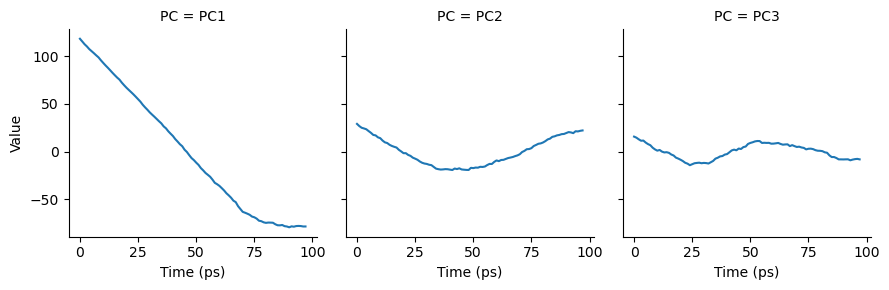

In [17]:
# melt the dataframe into a tidy format
melted = pd.melt(df, id_vars=["Time (ps)"],
                 var_name="PC",
                 value_name="Value")
g = sns.FacetGrid(melted, col="PC")
g.map(sns.lineplot, 
      "Time (ps)", # x-axis
      "Value", # y-axis
      ci=None) # no confidence interval

## References

[1] Andrea Amadei, Antonius B.&nbsp;M. Linssen, and Herman J.&nbsp;C. Berendsen.
Essential dynamics of proteins.
<em>Proteins: Structure, Function, and Bioinformatics</em>, 17(4):412–425, 1993.
_eprint: https://onlinelibrary.wiley.com/doi/pdf/10.1002/prot.340170408.
URL: <a href="http://onlinelibrary.wiley.com/doi/abs/10.1002/prot.340170408">http://onlinelibrary.wiley.com/doi/abs/10.1002/prot.340170408</a>, <a href="https://doi.org/https://doi.org/10.1002/prot.340170408">doi:https://doi.org/10.1002/prot.340170408</a>.

[2] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[3] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[4] I.&nbsp;T. Jolliffe.
<em>Principal <span class="bibtex-protected">Component</span> <span class="bibtex-protected">Analysis</span></em>.
Springer <span class="bibtex-protected">Series</span> in <span class="bibtex-protected">Statistics</span>.
Springer-Verlag, New York, 2 edition, 2002.
ISBN 978-0-387-95442-4.
URL: <a href="http://www.springer.com/gp/book/9780387954424">http://www.springer.com/gp/book/9780387954424</a>, <a href="https://doi.org/10.1007/b98835">doi:10.1007/b98835</a>.

[5] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[6] Florian Sittel, Abhinav Jain, and Gerhard Stock.
Principal component analysis of molecular dynamics: on the use of <span class="bibtex-protected">Cartesian</span> vs. internal coordinates.
<em>The Journal of Chemical Physics</em>, 141(1):014111, July 2014.
<a href="https://doi.org/10.1063/1.4885338">doi:10.1063/1.4885338</a>.

[7] Florian Sittel and Gerhard Stock.
Perspective: <span class="bibtex-protected">Identification</span> of collective variables and metastable states of protein dynamics.
<em>The Journal of Chemical Physics</em>, 149(15):150901, October 2018.
Publisher: American Institute of Physics.
URL: <a href="http://aip.scitation.org/doi/10.1063/1.5049637">http://aip.scitation.org/doi/10.1063/1.5049637</a>, <a href="https://doi.org/10.1063/1.5049637">doi:10.1063/1.5049637</a>.